In [100]:
import numpy as np
from datetime import datetime
from web3 import Web3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dotenv import load_dotenv
import os
import requests
from tqdm import tqdm

load_dotenv()

ETHERSCAN_KEY = os.getenv("ETHERSCAN_KEY")
ARBISCAN_KEY = os.getenv("ARBISCAN_KEY") 

API_ETH = os.getenv("API_ETH")
API_ARB = os.getenv("API_ARB")

In [2]:
# ABI for Chainlink Data Feed (simplified)
chainlink_abi = '''
[
    {
        "constant": true,
        "inputs": [],
        "name": "latestAnswer",
        "outputs": [
            {
                "name": "",
                "type": "int256"
            }
        ],
        "payable": false,
        "stateMutability": "view",
        "type": "function"
    }
]
'''

In [17]:
import json

with open('BalancerPoolABI.json') as f:
    pool_abi = json.load(f)
    pool_abi = pool_abi['result']
    
    
web3 = Web3(Web3.HTTPProvider(API_ARB))
block = web3.eth.get_block('latest')

contract = web3.eth.contract(address="0xB61371Ab661B1ACec81C699854D2f911070C059E", abi=pool_abi)

contract.functions.getActualSupply().call(block_identifier=203978517)

479093342650264537608

https://api.arbiscan.io/api?module=block&action=getblocknobytime&timestamp=1713920400&closest=before&apikey=BV19UTEB7H52AFWTIUXK2H7P5QFIR71JBB
https://api.etherscan.io/api?module=block&action=getblocknobytime&timestamp=1713920400&closest=before&apikey=CD5ZT9NFC5WGFRGVCNAHCHS8DCMDE3CND7 (18:30 PT)

https://api.arbiscan.io/api?module=block&action=getblocknobytime&timestamp=1713916800&closest=before&apikey=BV19UTEB7H52AFWTIUXK2H7P5QFIR71JBB
https://api.etherscan.io/api?module=block&action=getblocknobytime&timestamp=1713920400&closest=before&apikey=CD5ZT9NFC5WGFRGVCNAHCHS8DCMDE3CND7 (18:30 PT)

In [114]:
   

#get the block numbers to start
start_time = 1713913200

arb_block_start = int(requests.get(f'https://api.arbiscan.io/api?module=block&action=getblocknobytime&timestamp={start_time}&closest=before&apikey={ARBISCAN_KEY}').json()['result'])
eth_block_start = int(requests.get(f'https://api.etherscan.io/api?module=block&action=getblocknobytime&timestamp={start_time}&closest=before&apikey={ETHERSCAN_KEY}').json()['result'])


In [132]:
import json

BPT_DECIMALS = 1e18

num_hours = 6

START_HEIGHT = 19721825
START_HEIGHT = eth_block_start
END_HEIGHT = int(START_HEIGHT + (num_hours*60*60) // 13.5) # 6 hours worth of blocks
INTERVAL = int(5*60 // 13.5) #blocks 
block_range = range(START_HEIGHT, END_HEIGHT + 1, INTERVAL)

START_ARB = 204173620
START_ARB = arb_block_start
END_ARB = int(START_ARB + (num_hours*60*60) // 0.26) # 6 hours worth of blocks
# END_ARB = 204583516
INTERVAL_ARB = int(5*60 // 0.26) #blocks
arb_block_range = range(START_ARB, END_ARB + 1, INTERVAL_ARB)


with open('BalancerVaultABI.json') as f:
    vault_abi = json.load(f)
    vault_abi = vault_abi['result']
    
with open('BalancerPoolABI.json') as f:
    pool_abi = json.load(f)
    pool_abi = pool_abi['result']
    
#mainnet
contract_address = "0x596192bB6e41802428Ac943D2f1476C1Af25CC0E"
vault_address = '0xBA12222222228d8Ba445958a75a0704d566BF2C8'
chainlink_eth_usd = '0x5f4eC3Df9cbd43714FE2740f5E3616155c5b8419'
chainlink_ezeth_eth = '0x636A000262F6aA9e1F094ABF0aD8f645C44f641C'
pool_id = '0x596192bb6e41802428ac943d2f1476c1af25cc0e000000000000000000000659'

#arbitrum
arb_contract_address = "0xB61371Ab661B1ACec81C699854D2f911070C059E"
arb_vault = "0xBA12222222228d8Ba445958a75a0704d566BF2C8"
oracle_ez_arb = "0x11E1836bFF2ce9d6A5bec9cA79dc998210f3886d"
oracle_eth_arb = "0x639Fe6ab55C921f74e7fac1ee960C0B6293ba612"
arb_pool_id = "0xb61371ab661b1acec81c699854d2f911070c059e000000000000000000000516"

def call_get_rate(contract, block_height):
    try:
        rate = contract.functions.getRate().call(block_identifier=block_height)
        return rate
    except Exception as e:
        print(f"Error calling getRate at block {block_height}: {e}")

def getPoolTokens(contract, block_height, pool_id):
    pool_tokens = contract.functions.getPoolTokens(pool_id).call(block_identifier=block_height)
    return pool_tokens

def getChainLinkRate(web3, chainlink_address, block_height, decimals):
    chainlink_contract = web3.eth.contract(address=chainlink_address, abi=chainlink_abi)
    rate = chainlink_contract.functions.latestAnswer().call(block_identifier=block_height)/decimals
    return rate

def getData(web3, block_range, contract_address, vault_address, chainlink_eth_usd, chainlink_ezeth_eth, pool_id):
    vault = web3.eth.contract(address=vault_address, abi=vault_abi)
    pool = web3.eth.contract(address=contract_address, abi=pool_abi)
    
    pool_tokens_data = []
    ezeth_eth_rate_data = []
    eth_usd_rate_data = []
    timestamps = []
    bpt_supply_data = []
    scaling_factors_data = []

    print(f"TOTAL BLOCKS: {len(block_range)}")

    for block_height in block_range:
        print(f"Getting data for block {block_height}")
        
        #get supply 
        supply = pool.functions.getActualSupply().call(block_identifier=block_height)
        bpt_supply_data.append(supply/BPT_DECIMALS)
        
        scaling_factors = pool.functions.getScalingFactors().call(block_identifier=block_height)
        scaling_factors_data.append(scaling_factors)
        print(f"Scaling factors: {scaling_factors}")
        
        #get block timestamp
        block = web3.eth.get_block(block_height)
        timestamp = block['timestamp']
        print(f"Block timestamp: {datetime.fromtimestamp(timestamp)}")
        
        ezeth_eth_rate = getChainLinkRate(web3, chainlink_ezeth_eth, block_height, 1e18)
        # eth_usd_rate = getChainLinkRate(web3, chainlink_eth_usd, block_height, 1e8)
        # bpt_rate_in_eth = call_get_rate(block_height)/1e18
        pool_tokens = getPoolTokens(vault, block_height, pool_id)
        
        pool_tokens_data.append(pool_tokens)
        ezeth_eth_rate_data.append(ezeth_eth_rate)
        # eth_usd_rate_data.append(eth_usd_rate)
        # bpt_rate_data.append(bpt_rate_in_eth)
        timestamps.append(timestamp)
        
        print(f"The latest ezETH/WETH price is: {ezeth_eth_rate}")
        # print(f"The latest BPT price in ETH is: {bpt_rate_in_eth}")
        # print(f"The latest ETH/USD price is: {eth_usd_rate}")

        
    return pool_tokens_data, ezeth_eth_rate_data, eth_usd_rate_data, timestamps, bpt_supply_data, scaling_factors_data

print("### ETH ###")
web3 = Web3(Web3.HTTPProvider(API_ETH))
pool_tokens_data, ezeth_eth_rate_data, eth_usd_rate_data, timestamps, bpt_supply_data, scaling_factors_data = getData(web3, block_range, contract_address, vault_address, chainlink_eth_usd, chainlink_ezeth_eth, pool_id)

print("### ARBITRUM ###")
web3 = Web3(Web3.HTTPProvider(API_ARB))
pool_tokens_data_arb, ezeth_eth_rate_data_arb, eth_usd_rate_data_arb, timestamps_arb, bpt_supply_data_arb, scaling_factors_data_arb = getData(web3, arb_block_range, arb_contract_address, arb_vault, oracle_eth_arb, oracle_ez_arb, arb_pool_id)



### ETH ###
TOTAL BLOCKS: 73
Getting data for block 19721232
Scaling factors: [1000000000000000000, 1008284209229107212, 1000000000000000000]
Block timestamp: 2024-04-23 15:59:59
The latest ezETH/WETH price is: 1.0081161632063758
Getting data for block 19721254
Scaling factors: [1000000000000000000, 1008284209229107212, 1000000000000000000]
Block timestamp: 2024-04-23 16:04:35
The latest ezETH/WETH price is: 1.0081161632063758
Getting data for block 19721276
Scaling factors: [1000000000000000000, 1008284209229107212, 1000000000000000000]
Block timestamp: 2024-04-23 16:08:59
The latest ezETH/WETH price is: 1.0081161632063758
Getting data for block 19721298
Scaling factors: [1000000000000000000, 1008284209229107212, 1000000000000000000]
Block timestamp: 2024-04-23 16:13:23
The latest ezETH/WETH price is: 1.0081161632063758
Getting data for block 19721320
Scaling factors: [1000000000000000000, 1008284209229107212, 1000000000000000000]
Block timestamp: 2024-04-23 16:17:47
The latest ezETH/

In [127]:
timestamps = [datetime.fromtimestamp(ts) for ts in timestamps]
timestamps_arb = [datetime.fromtimestamp(ts) for ts in timestamps_arb]

# scaling_factors = [1000000000000000000, 1012126580662408076, 1000000000000000000]
# scaling_factors_arb = [1012128187462516518, 1169781604352280999, 1000000000000000000 ]

bpt_vals = []
ezeth_amts = []
ezeth_vals = []
weth_amts = []

for i,data in enumerate(pool_tokens_data):
    ezeth_amts.append(data[1][1]/scaling_factors_data[i][1])
    weth_amts.append(data[1][2]/scaling_factors_data[i][2])
    ezeth_vals.append(ezeth_amts[i]*ezeth_eth_rate_data[i])
    bpt_vals.append((ezeth_vals[i] + weth_amts[i])/bpt_supply_data[i])
    
bpt_vals_arb = []
ezeth_amts_arb = []
ezeth_vals_arb = []
weth_amts_arb = []

for i,data in enumerate(pool_tokens_data_arb):
    ezeth_amts_arb.append(data[1][0]/scaling_factors_data_arb[i][0])
    weth_amts_arb.append(data[1][1]/scaling_factors_data_arb[i][1])
    ezeth_vals_arb.append(ezeth_amts_arb[i]*ezeth_eth_rate_data_arb[i])
    bpt_vals_arb.append((ezeth_vals_arb[i] + weth_amts_arb[i])/bpt_supply_data_arb[i])



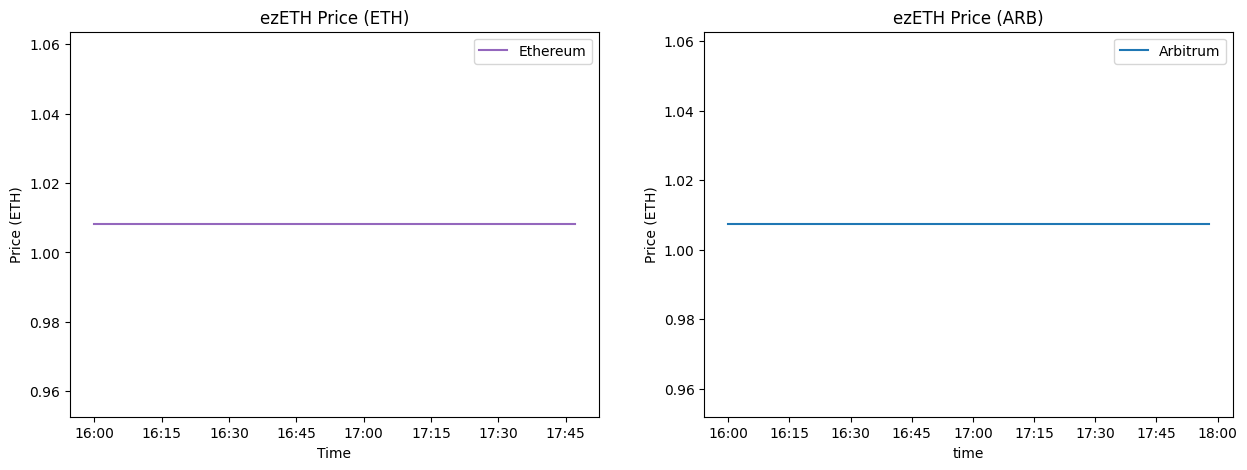

In [128]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

color='tab:purple'
ax[0].set_xlabel('Time')
ax[0].set_title('ezETH Price (ETH)')
ax[0].set_ylabel('Price (ETH)')
ax[0].plot(timestamps, ezeth_eth_rate_data, label='Ethereum', color=color)
ax[0].tick_params(axis='y')
ax[0].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(myFmt)

color='tab:blue'
ax[1].set_title('ezETH Price (ARB)')
ax[1].set_xlabel('time')
ax[1].set_ylabel('Price (ETH)')
ax[1].plot(timestamps_arb, ezeth_eth_rate_data_arb, label='Arbitrum', color=color)
ax[1].tick_params(axis='y')
ax[1].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[1].xaxis.set_major_formatter(myFmt)



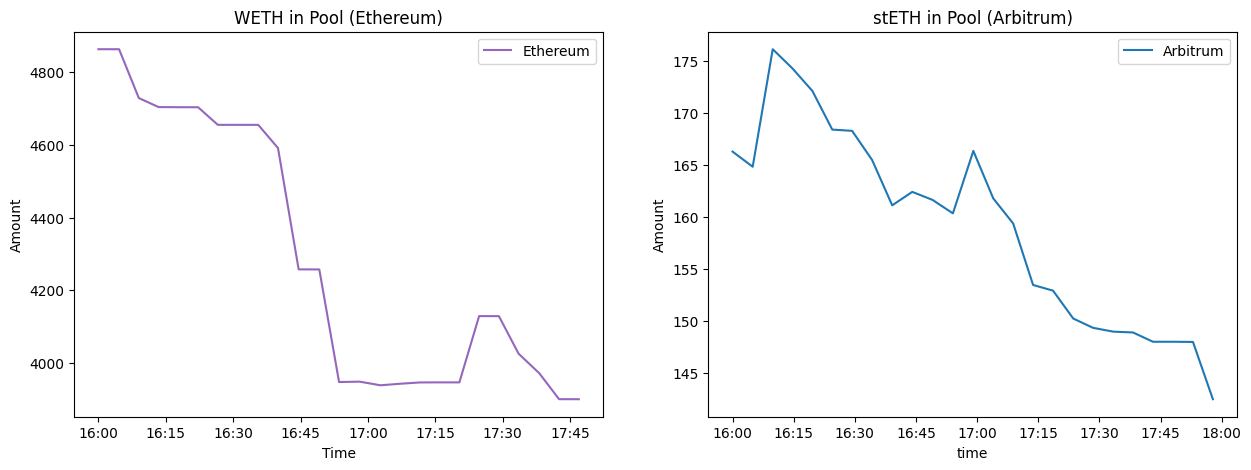

In [129]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

color='tab:purple'
ax[0].set_xlabel('Time')
ax[0].set_title('WETH in Pool (Ethereum)')
ax[0].set_ylabel('Amount')
ax[0].plot(timestamps, weth_amts, label='Ethereum', color=color)
ax[0].tick_params(axis='y')
ax[0].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(myFmt)

color='tab:blue'
ax[1].set_title('stETH in Pool (Arbitrum)')
ax[1].set_xlabel('time')
ax[1].set_ylabel('Amount')
ax[1].plot(timestamps_arb, weth_amts_arb, label='Arbitrum', color=color)
ax[1].tick_params(axis='y')
ax[1].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[1].xaxis.set_major_formatter(myFmt)



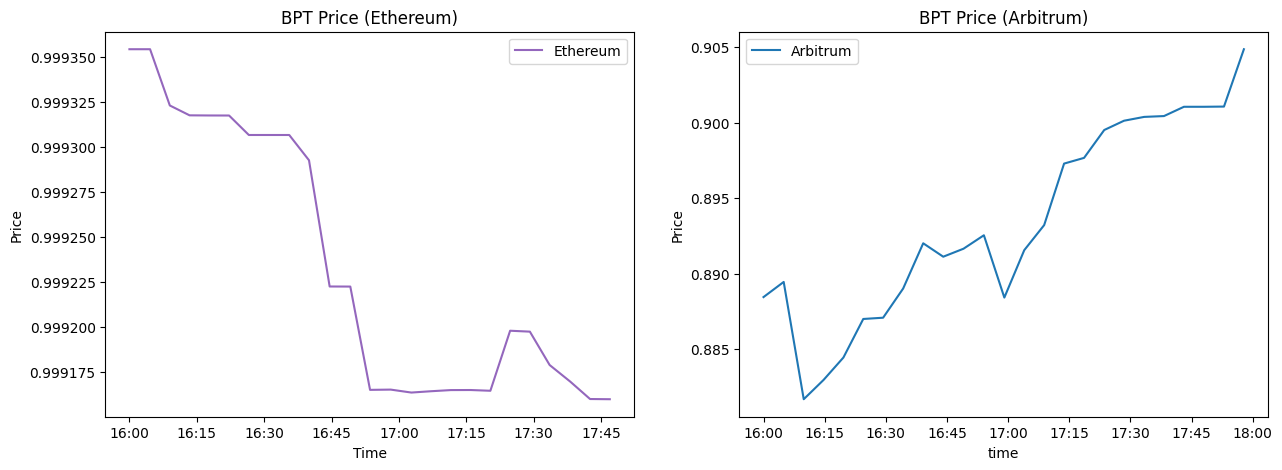

In [130]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

color='tab:purple'
ax[0].set_xlabel('Time')
ax[0].set_title('BPT Price (Ethereum)')
ax[0].set_ylabel('Price')
ax[0].plot(timestamps, bpt_vals, label='Ethereum', color=color)
ax[0].tick_params(axis='y')
ax[0].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(myFmt)

color='tab:blue'
ax[1].set_title('BPT Price (Arbitrum)')
ax[1].set_xlabel('time')
ax[1].set_ylabel('Price')
ax[1].plot(timestamps_arb, bpt_vals_arb, label='Arbitrum', color=color)
ax[1].tick_params(axis='y')
ax[1].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[1].xaxis.set_major_formatter(myFmt)



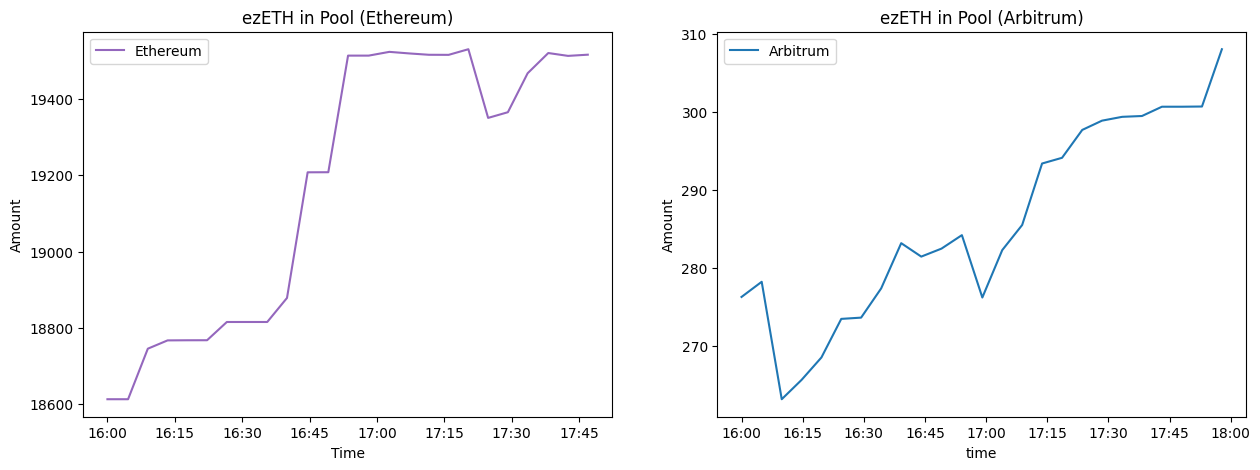

In [131]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

color='tab:purple'
ax[0].set_xlabel('Time')
ax[0].set_title('ezETH in Pool (Ethereum)')
ax[0].set_ylabel('Amount')
ax[0].plot(timestamps, ezeth_amts, label='Ethereum', color=color)
ax[0].tick_params(axis='y')
ax[0].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(myFmt)

color='tab:blue'
ax[1].set_title('ezETH in Pool (Arbitrum)')
ax[1].set_xlabel('time')
ax[1].set_ylabel('Amount')
ax[1].plot(timestamps_arb, ezeth_amts_arb, label='Arbitrum', color=color)
ax[1].tick_params(axis='y')
ax[1].legend()

# beautify the x-labels
myFmt = mdates.DateFormatter('%H:%M')
ax[1].xaxis.set_major_formatter(myFmt)

